In [6]:
import gdown
train_file_id = '1CX_H9PXRdCEhRx14ifDObqkhuqOXCWZQ'
gdown.download(f'https://drive.google.com/uc?export=download&id={train_file_id}', 'train_punctuation_data.jsonl', quiet=False)
dev_file_id = '1XnJmiji-NCE-goVCxCKfguUnt6mMRoYU'
gdown.download(f'https://drive.google.com/uc?export=download&id={dev_file_id}', 'dev_punctuation_data.jsonl', quiet=False)
test_file_id = '1hqfZq0vKoBqWcUur2on0gqOqHHKOe_Jb'
gdown.download(f'https://drive.google.com/uc?export=download&id={test_file_id}', 'test_punctuation_data.jsonl', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1CX_H9PXRdCEhRx14ifDObqkhuqOXCWZQ
To: /kaggle/working/train_punctuation_data.jsonl
100%|██████████| 3.39M/3.39M [00:00<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1XnJmiji-NCE-goVCxCKfguUnt6mMRoYU
To: /kaggle/working/dev_punctuation_data.jsonl
100%|██████████| 463k/463k [00:00<00:00, 93.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hqfZq0vKoBqWcUur2on0gqOqHHKOe_Jb
To: /kaggle/working/test_punctuation_data.jsonl
100%|██████████| 800k/800k [00:00<00:00, 115MB/s]


'test_punctuation_data.jsonl'

In [7]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import MBart50TokenizerFast, MBartModel
from torch import nn, optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split


def load_tokens_and_labels(filepath):
    tokens, labels = [], []
    with open(filepath, 'r') as f:
        for line in f:
            item = json.loads(line)
            tokens.append(item['tokens_per_sentence'])
            label = item['labels']
            label.insert(0, -99)
            label.append(-99)
            label = [l - 1 for l in label]
            labels.append(label)
    return tokens, labels


# Load the data
train_tokens, train_labels = load_tokens_and_labels("train_punctuation_data.jsonl")
dev_tokens, dev_labels = load_tokens_and_labels("dev_punctuation_data.jsonl")
test_tokens, test_labels = load_tokens_and_labels("test_punctuation_data.jsonl")


# Dataset class
tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50')

class TokenClassificationDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        encoding = tokenizer(self.tokens[idx],
                             is_split_into_words=True,
                             padding=False,
                             truncation=True,
                             return_tensors=None)
        input_ids = torch.tensor(encoding['input_ids'])
        attention_mask = torch.tensor(encoding['attention_mask'])
        return {'input_ids': input_ids, 'attention_mask': attention_mask}, self.labels[idx]


# Collate Function
def collate_fn(batch):
    filtered_batch = [item for item in batch if item[0]['input_ids'].size(0) <= 60]
    discarded = len(batch) - len(filtered_batch)
    if len(filtered_batch) == 0:
        return None, None, discarded

    max_length = max(item[0]['input_ids'].size(0) for item in filtered_batch)

    input_ids = torch.stack([
        torch.cat([item[0]['input_ids'], torch.zeros(max_length - item[0]['input_ids'].size(0), dtype=torch.long)])
        for item in filtered_batch
    ])
    attention_mask = torch.stack([
        torch.cat([item[0]['attention_mask'], torch.zeros(max_length - item[0]['attention_mask'].size(0), dtype=torch.long)])
        for item in filtered_batch
    ])
    labels = torch.stack([
        torch.cat([torch.tensor(item[1], dtype=torch.long), torch.full((max_length - len(item[1]),), -100, dtype=torch.long)])
        for item in filtered_batch
    ])

    return {'input_ids': input_ids.to(device), 'attention_mask': attention_mask.to(device)}, labels.to(device), discarded



# Model class
class PunctuationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(PunctuationModel, self).__init__()
        self.mbart = MBartModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.mbart.config.d_model, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.mbart(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        logits = self.classifier(hidden_states)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and loaders
train_dataset = TokenClassificationDataset(train_tokens, train_labels)
dev_dataset = TokenClassificationDataset(dev_tokens, dev_labels)
test_dataset = TokenClassificationDataset(test_tokens, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn, shuffle=False)

# Training and Evaluation
model = PunctuationModel('facebook/mbart-large-50', num_labels=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()


def evaluate(dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    total_discarded = 0
    running_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:
                total_discarded += batch[2]
                continue

            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            logits = model(input_ids, attention_mask=attention_mask)

            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            loss = loss_fn(logits, labels)
            running_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            mask = labels != -100
            all_preds.extend(preds[mask].tolist())
            all_labels.extend(labels[mask].tolist())

    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, total_discarded



def train_one_epoch(dataloader):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []
    total_discarded = 0

    for batch in dataloader:
        if batch[0] is None:
            total_discarded += batch[2]
            continue

        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1]
        discarded = batch[2]
        total_discarded += discarded

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)

        logits = logits.view(-1, logits.shape[-1])
        labels = labels.view(-1)

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        mask = labels != -100
        all_preds.extend(preds[mask].tolist())
        all_labels.extend(labels[mask].tolist())

    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, total_discarded



# Early stopping training loop
def train_for_epochs(train_loader, val_loader, epochs=10, patience=2):
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss, train_acc, train_discarded = train_one_epoch(train_loader)
        val_loss, val_acc, val_discarded = evaluate(val_loader)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Discarded: {train_discarded}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Discarded: {val_discarded}")
        print('-' * 60)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_mbart_punctuation_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print(f"Final Train Accuracy: {train_acc:.4f} | Final Dev Accuracy: {val_acc:.4f}")


train_for_epochs(train_loader, dev_loader, epochs=10, patience=2)

# Load best model and evaluate on test
model.load_state_dict(torch.load('best_mbart_punctuation_model.pt'))
test_acc = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch 1/10
Train Loss: 0.6090 | Train Acc: 0.8418 | Discarded: 34
Val   Loss: 0.3734 | Val   Acc: 0.8849 | Discarded: 0
------------------------------------------------------------

Epoch 2/10
Train Loss: 0.3046 | Train Acc: 0.9037 | Discarded: 34
Val   Loss: 0.3358 | Val   Acc: 0.8921 | Discarded: 0
------------------------------------------------------------

Epoch 3/10
Train Loss: 0.2292 | Train Acc: 0.9307 | Discarded: 34
Val   Loss: 0.5842 | Val   Acc: 0.8539 | Discarded: 0
------------------------------------------------------------

Epoch 4/10
Train Loss: 0.5770 | Train Acc: 0.8594 | Discarded: 34
Val   Loss: 0.5418 | Val   Acc: 0.8539 | Discarded: 0
------------------------------------------------------------
Early stopping triggered.
Final Train Accuracy: 0.8594 | Final Dev Accuracy: 0.8539


/tmp/ipykernel_31/1273356318.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mbart_punctuation_model.pt'))


TypeError: unsupported format string passed to tuple.__format__

In [12]:
test_loss, test_acc, test_discarded = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Discarded: {test_discarded}")


Test Loss: 0.3315 | Test Accuracy: 0.8942 | Discarded: 0


In [35]:
from sklearn.metrics import precision_recall_fscore_support

def overall_metrics(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:
                continue

            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            logits = model(input_ids, attention_mask=attention_mask)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            preds = torch.argmax(logits, dim=1)
            mask = (labels != -100) & (labels != -1)
            all_preds.extend(preds[mask].tolist())
            all_labels.extend(labels[mask].tolist())

    for avg in ['micro', 'macro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average=avg
        )
        print(f"\nIn {avg} setting:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")

overall_metrics(test_loader)


In micro setting:
Precision: 0.8535
Recall:    0.8535
F1-score:  0.8535

In macro setting:
Precision: 0.3006
Recall:    0.3135
F1-score:  0.2833

In weighted setting:
Precision: 0.8377
Recall:    0.8535
F1-score:  0.8363


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import classification_report

def evaluate_per_class(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:
                continue

            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            logits = model(input_ids, attention_mask=attention_mask)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            preds = torch.argmax(logits, dim=1)
            mask = (labels != -100) & (labels != -1)  # exclude padding and special tokens
            all_preds.extend(preds[mask].tolist())
            all_labels.extend(labels[mask].tolist())

    label_names = [
        "COMMA",     
        "PERIOD",    
        "QUESTION",  
        "QUOTES",    
        "HYPHEN"  ,
        "O", 
    ]

    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

evaluate_per_class(test_loader)

              precision    recall  f1-score   support

       COMMA     0.3923    0.0920    0.1490      1109
      PERIOD     0.4998    0.8664    0.6339      1198
    QUESTION     0.0000    0.0000    0.0000         2
      QUOTES     0.0000    0.0000    0.0000        81
      HYPHEN     0.0000    0.0000    0.0000       160
           O     0.9113    0.9228    0.9170     14971

    accuracy                         0.8535     17521
   macro avg     0.3006    0.3135    0.2833     17521
weighted avg     0.8377    0.8535    0.8363     17521



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from collections import defaultdict
import numpy as np
def per_class_accuracy(dataloader):
    model.eval()
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:
                continue

            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            logits = model(input_ids, attention_mask=attention_mask)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)
            preds = torch.argmax(logits, dim=1)

            mask = (labels != -100) & (labels != -1)
            labels = labels[mask]
            preds = preds[mask]

            for true_label, pred_label in zip(labels.tolist(), preds.tolist()):
                class_total[true_label] += 1
                if true_label == pred_label:
                    class_correct[true_label] += 1

    label_names = [
        "COMMA",     
        "PERIOD",    
        "QUESTION",  
        "QUOTES",    
        "HYPHEN"  ,
        "O", 
    ]

    print("Per-class Accuracy:")
    print(f"{'Class':10s} {'Total':>6s} {'Correct':>8s} {'Accuracy':>10s}")
    print("-" * 38)
    for idx, name in enumerate(label_names):
        total = class_total[idx]
        correct = class_correct[idx]
        acc = correct / total if total > 0 else 0.0
        print(f"{name:10s} {total:6d} {correct:8d} {acc:10.4f}")

per_class_accuracy(test_loader)


Per-class Accuracy:
Class       Total  Correct   Accuracy
--------------------------------------
COMMA        1109      102     0.0920
PERIOD       1198     1038     0.8664
QUESTION        2        0     0.0000
QUOTES         81        0     0.0000
HYPHEN        160        0     0.0000
O           14971    13815     0.9228


Confusion Matrix:
[[  102    23     0     0     0   984]
 [    2  1038     0     0     0   158]
 [    0     2     0     0     0     0]
 [   10     7     0     0     0    64]
 [    2    20     0     0     0   138]
 [  144   987     0     0    25 13815]]


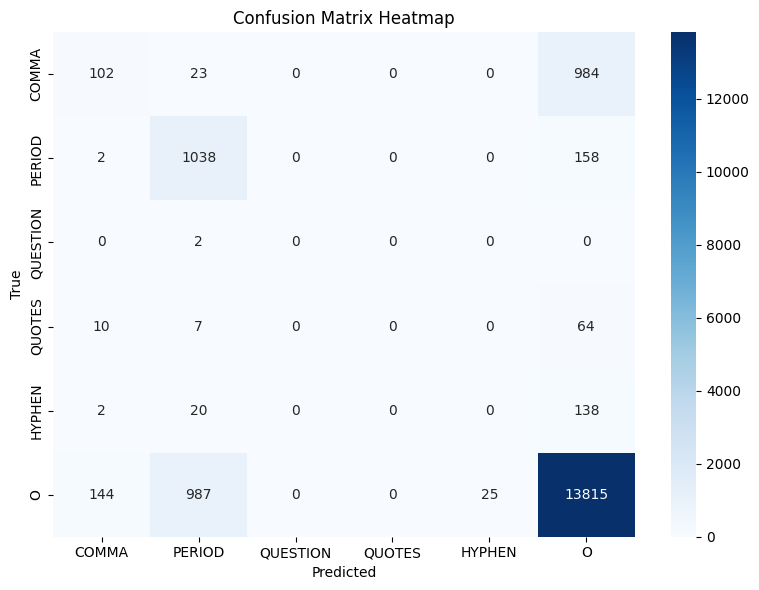

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:
                continue

            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']
            labels = batch[1]

            logits = model(input_ids, attention_mask=attention_mask)
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.view(-1)

            preds = torch.argmax(logits, dim=1)
            mask = (labels != -100) & (labels != -1)
            all_preds.extend(preds[mask].tolist())
            all_labels.extend(labels[mask].tolist())

    label_names = [
        "COMMA",     
        "PERIOD",    
        "QUESTION",  
        "QUOTES",    
        "HYPHEN"  ,
        "O", 
    ]
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(label_names))))

    print("Confusion Matrix:")
    print(cm)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_loader)


In [14]:
import os

# Load tokenizer and model
tokenizer = MBartTokenizerFast.from_pretrained('facebook/mbart-large-50')
model.eval()  # Set model to eval mode

# Make sure model and tokenizer match your trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Path to your test jsonl file
input_path = 'test_punctuation_data.jsonl'
output_dir = 'test_text_punct_features/'  # Folder to save features

os.makedirs(output_dir, exist_ok=True)

with open(input_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Extracting features"):
    sample = json.loads(line)
    uid = sample['id']
    original_text = sample['original_text']

    # Tokenize
    encoded = tokenizer(original_text, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model.mbart(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state.squeeze(0).cpu()  # [seq_len, hidden_size]

    # Save to a file named by ID
    torch.save(last_hidden_state, f"{output_dir}/{uid}.pt")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizerFast'.
Extracting features: 100%|██████████| 647/647 [00:13<00:00, 48.38it/s]


In [19]:
# Path to your test jsonl file
input_path = 'dev_punctuation_data.jsonl'
output_dir = 'dev_text_punct_features/'  # Folder to save features

os.makedirs(output_dir, exist_ok=True)

with open(input_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Extracting features"):
    sample = json.loads(line)
    uid = sample['id']
    original_text = sample['original_text']

    # Tokenize
    encoded = tokenizer(original_text, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    with torch.no_grad():
            outputs = model.mbart(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state.squeeze(0).cpu()  # [seq_len, hidden_size]
    
    # Save to a file named by ID
    torch.save(last_hidden_state, f"{output_dir}/{uid}.pt")

Extracting features: 100%|██████████| 394/394 [00:08<00:00, 48.91it/s]


In [20]:
import shutil

shutil.make_archive("dev_text_punct_features", 'zip', "dev_text_punct_features/")

from IPython.display import FileLink
FileLink('dev_text_punct_features.zip')


/kaggle/working/dev_text_punct_features.zip

In [21]:
import shutil

shutil.make_archive("test_text_punct_features", 'zip', "test_text_punct_features/")

from IPython.display import FileLink
FileLink('test_text_punct_features.zip')


/kaggle/working/test_text_punct_features.zip

In [22]:
# Path to your test jsonl file
input_path = 'train_punctuation_data.jsonl'
output_dir = 'train_text_punct_features/'  # Folder to save features

os.makedirs(output_dir, exist_ok=True)

with open(input_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Extracting features"):
    sample = json.loads(line)
    uid = sample['id']
    original_text = sample['original_text']

    # Tokenize
    encoded = tokenizer(original_text, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    with torch.no_grad():
            outputs = model.mbart(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state.squeeze(0).cpu()  # [seq_len, hidden_size]
    
    # Save to a file named by ID
    torch.save(last_hidden_state, f"{output_dir}/{uid}.pt")

Extracting features: 100%|██████████| 2518/2518 [00:53<00:00, 47.10it/s]


In [23]:
import shutil

shutil.make_archive("train_text_punct_features", 'zip', "train_text_punct_features/")

from IPython.display import FileLink
FileLink('train_text_punct_features.zip')


/kaggle/working/train_text_punct_features.zip